In [1]:
import gym
import collections
import random
import time
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import *
from IPython.display import clear_output
import time
import csv
from gym import envs
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential, load_model
from keras import regularizers, optimizers
from keras.utils import to_categorical
#np.random.seed(1234)
import scipy.io as sio
import scipy as scp
from scipy import stats
import operator
from keras import backend as K
import tensorflow as tf
import os
import keras
from keras.models import load_model
from IPython.display import display, clear_output
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'
#config=tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction=0.5
#set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#all_envs = envs.registry.all()
#env_ids = [env_spec.id for env_spec in all_envs]
#print(np.transpose(env_ids)) 

In [3]:
# FF
class DQNAgent:
    def __init__(self):
        #(210,160,3),6
        self.drop = 0
        self.state_size = (4,)
        self.action_size = 2 # 9 for pacman, 6 for space invader
        self.memory = collections.deque(maxlen=2000)
        self.gamma = 0.95    # discount rate 0.95
        self.epsilon = 1  # exploration rate 1 
        self.epsilon_min = 0.01
        self.epsilon_decay = []
        self.learning_rate = []
        self.time_penalty = 0
        self.model = []
        self.target_model = []
        self.target_update_rate = []
        self.fix = False
        self.optimizer_param = []
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        
        model.add(Dense(24, input_shape=self.state_size, activation='linear'))
        #model.add(Dropout(self.drop))
                
        model.add(Dense(24, activation='relu'))
        model.add(Dropout(self.drop))
        
#         model.add(Dense(128, activation='relu'))
#         #model.add(Dropout(self.drop))

#         model.add(Dense(128, activation='relu'))
#         #model.add(Dropout(self.drop))
        
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=self.optimizer_param)
        #model.compile(loss=huber_loss, optimizer=self.optimizer_param)
        #model.summary()
        return model
    
    def copy_model(self):
        
        self.target_model.set_weights(self.model.get_weights())
        return []
    
    #def copy_model(self):
    #    self.model.save('tmp_model')
    #    self.target_model = keras.models.load_model('tmp_model')
    #    return []
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            act_values = np.zeros((1,self.action_size))
            return act_values,env.action_space.sample()
        state = np.expand_dims(state,axis=0)
        #print(state.shape)
        act_values = self.model.predict(state)
        return act_values,np.argmax(act_values)   # returns action
    
    def replay(self, batch_size,e):
        minibatch = random.sample(self.memory, batch_size)
        
        if e%self.target_update_rate == 0:
            self.copy_model()
            
        for state, action, reward, next_state, done in minibatch:
            state = np.expand_dims(state,axis=0)
            next_state = np.expand_dims(next_state,axis=0)
            target = 0 #if we are done the final reward is our target
            if not done: #if we are not done the target is the current reward plut the predicted reward from the next state
                
                #Normal Q
                target = reward + self.gamma * np.amax(self.model.predict(next_state))
                
                #Double Q
                #target = reward + self.gamma * np.amax(self.target_model.predict(next_state))

            target_f = self.model.predict(state) 
            #print(target_f)
            target_f[0][action] = target - self.time_penalty
            
            self.model.fit(state, target_f, epochs=1, verbose=0) 
            
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon-self.epsilon_decay
        
def huber_loss(y_true, y_pred):
    clip_delta=2.0
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)        

In [4]:
def train_agent(agent,env,episodes,iteration,iterations,fix):
    total_reward_counter = np.empty([episodes])
    Q_reward_counter = np.empty([episodes])
    #agent.epsilon = 1
    for e in range(episodes):
        
        if e > fix: 
            agent.fix = False
        
        total_reward = 0
        state = env.reset()
        state, reward, done, info = env.step(0)
        for time_t in range(1000000):

            actvals, action = agent.act(state)
            
            next_state, reward, done, info = env.step(action)
        
            total_reward = total_reward + reward   

            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                clear_output(wait=True)
                print("iteration: {}/{}, episode: {}/{}, score: {}, epsilon: {}".format(iteration+1,iterations ,e+1, episodes, total_reward, agent.epsilon,2))
                Q_reward_counter[e] = np.max(actvals)
                total_reward_counter[e] = total_reward

                break
        if agent.fix == False:
            agent.replay(32,e)
    return Q_reward_counter, total_reward_counter

In [5]:
#env = gym.make('SpaceInvaders-v0')
env = gym.make('CartPole-v1')
balls = np.zeros(1000)
for i in  range(1000):
    balls[i] = env.action_space.sample()
print(np.max(balls)+1)
state = env.reset()
next_state, reward, done, info = env.step(1)
#lives_before = info['ale.lives']
print(info)
print(state*10000)
state.shape


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
2.0
{}
[ 246.22250852  322.62236221 -333.33429338   64.28160017]


(4,)

In [6]:
fix = 10
episodes = 1000 # 100.000

iterations = 20

target_update_rate = 10
target_update_rate = np.repeat(target_update_rate,iterations)

learning_rates = [0.001]#,0.0002,0.0002]
learning_rates = np.repeat(learning_rates,iterations)

decay = [0.0015]#,0.99992,0.99992]   #30.000eps
decay = np.repeat(decay,iterations)

#optim = ['rmsprop','adam','sgd']
optim = ['adam']
optim = np.repeat(optim,iterations)



total_rewards = np.empty([iterations,episodes])
Q_rewards = np.empty([iterations,episodes])

for iteration in range(iterations):
    env = gym.make('CartPole-v1')
     
    agent = DQNAgent()   
    
    agent.fix = True
        
    #Decay parameter
    agent.epsilon_decay = decay[iteration]
    
    agent.learning_rate = learning_rates[iteration]
    agent.target_update_rate = target_update_rate[iteration]
    
    if optim[iteration] == 'rmsprop':
        optimizer_param = optimizers.RMSprop(lr=agent.learning_rate)
        
    if optim[iteration] == 'adam':
        optimizer_param = optimizers.Adam(lr=agent.learning_rate)
        
    if optim[iteration] == 'sgd':
        optimizer_param = optimizers.SGD(lr=agent.learning_rate)
        
    agent.optimizer_param =  optimizer_param 
    
    agent.model = agent._build_model()
    agent.target_model = agent._build_model()
    agent.copy_model()
    #agent.target_model = agent._build_model()
    
    Q_reward_counter, total_reward_counter = train_agent(agent,env,episodes,iteration,iterations,fix)
    
    total_rewards[iteration][:] = total_reward_counter
    Q_rewards[iteration][:] = Q_reward_counter


iteration: 20/20, episode: 1000/1000, score: 499.0, epsilon: 0.008500000000017613


/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,1,'Q Values')

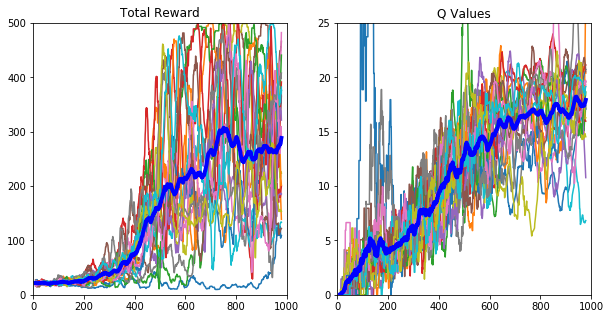

In [9]:
#iterations = 20
plt.figure(figsize=(10,5))
a = subplot(121)
#iterations = 10
iteration_value = optim
window = 10

total_avg_all = np.empty([iterations,episodes-(window*2)])
#x = np.arange(episodes)
for iteration in range(iterations):
    total_avg = np.zeros([episodes-(window*2)])
    for pnts in range(total_rewards[iteration].shape[0]-(window*2)):
        total_avg[pnts] =  np.mean(total_rewards[iteration][(pnts-window) : pnts+window])

    perf, = plt.plot(np.float32(total_avg),label = iteration_value[iteration])
    total_avg_all[iteration] = total_avg 
#legend()
plt.plot(np.mean(total_avg_all,0),linewidth=4.0,color='b')
plt.axis([0, episodes, 0, 500])
title('Total Reward')
subplot(122)

iteration_value = optim
window = 10

rew_avg_all = np.empty([iterations,episodes-(window*2)])
#x = np.arange(episodes)
for iteration in range(iterations):
    rew_avg = np.zeros([episodes-(window*2)])
    for pnts in range(Q_rewards[iteration].shape[0]-(window*2)):
        rew_avg[pnts] =  np.mean(Q_rewards[iteration][(pnts-window) : pnts+window])

    perf, = plt.plot(np.float32(rew_avg),label = iteration_value[iteration])
    rew_avg_all[iteration] = rew_avg 
#legend()
plt.plot(np.mean(rew_avg_all,0),linewidth=4.0,color='b')
plt.axis([0, episodes, 0, 25])
title('Q Values')

In [8]:
# x = np.linspace(0, 30, 30)
# y = np.sin(x/6*np.pi)
# error = np.random.normal(0.1, 0.02, size=y.shape)
# y += np.random.normal(0, 0.1, size=y.shape)

# pl.plot(x, y, 'k-')
# pl.fill_between(x, y-error, y+error)
# pl.show()